### Required Assignment 5.1: Will the Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\$20 - $50).

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece.





### Data Description
Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

#### Source of this data set
https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation

#### Analysit on github
https://github.com/mgk2014/PCMLAI-coupon

In [1264]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Problems

Use the prompts below to get started with your data analysis.  

1. Read in the `coupons.csv` file.




In [1265]:
data = pd.read_csv('data/coupons.csv')
data.sample(2)

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
132,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,26,Married partner,...,less1,gt8,4~8,never,1,0,0,0,1,1
11272,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Male,31,Single,...,4~8,4~8,4~8,1~3,1,0,0,1,0,1


2. Investigate the dataset for missing or problematic data.

In [1266]:
# find null or missing values
#
columns_with_nulls = data.isna().sum()

# find % of missing values
#
columns_with_nulls = (columns_with_nulls[columns_with_nulls.values > 0]/len(data))
columns_with_nulls


car                     0.991485
Bar                     0.008436
CoffeeHouse             0.017108
CarryAway               0.011905
RestaurantLessThan20    0.010249
Restaurant20To50        0.014901
dtype: float64

In [1267]:
# Check for categorical vallues
data['CoffeeHouse'].value_counts()

CoffeeHouse
less1    3385
1~3      3225
never    2962
4~8      1784
gt8      1111
Name: count, dtype: int64

---

**Observations of missing values**

- Categorical variables: CoffeeHouse, CarryAway, RestaurantLessThan20,Restaurant20To50, have less than .01% missing values
- These variables also have two values that donote the same meaning: never and less1 (or less than 1)
- Car column has 99%+ values missing

---

3. Decide what to do about your missing data -- drop, replace, other...

In [1268]:
# Strategy for missing data:
#
# A. Remove car column since car column is missing > 95% of its values
# B. For columns < 1% missing values, fill values of the most common value observed in that column
# C. Remove categorical values that appear to denote the same meaning
# D. Drop duplicates
# E. Add extra columns that translate coupon acceptance and direction in intuitive text
# 

# A. Remove Car Column
#
clean_data = data.drop(columns = columns_with_nulls[columns_with_nulls > 0.95].index)

# B. Update Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50
# columns and update missing values with the most common value observed. For this we will use the mode statistics
#

clean_data['Bar'] = data['Bar'].fillna(data['Bar'].mode)
clean_data['CoffeeHouse'] = data['CoffeeHouse'].fillna(data['CoffeeHouse'].mode)
clean_data['CarryAway'] = data['CarryAway'].fillna(data['CarryAway'].mode)
clean_data['RestaurantLessThan20'] = data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].mode)
clean_data['Restaurant20To50'] = data['Restaurant20To50'].fillna(data['Restaurant20To50'].mode)

# C. For the columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20','Restaurant20To50' 
# the value never and less1, appear to denote the same meaning. 
# So we will update the values with never, where less1 is present
# 
clean_data['Bar'] = clean_data['Bar'].map(lambda x: 'never' if x == 'less1' else x)
clean_data['CoffeeHouse'] = clean_data['CoffeeHouse'].map(lambda x: 'never' if x == 'less1' else x)
clean_data['CarryAway'] = clean_data['CarryAway'].map(lambda x: 'never' if x == 'less1' else x)
clean_data['RestaurantLessThan20'] = clean_data['RestaurantLessThan20'].map(lambda x: 'never' if x == 'less1' else x)
clean_data['Restaurant20To50'] = clean_data['Restaurant20To50'].map(lambda x: 'never' if x == 'less1' else x)

# D. drop duplicates
clean_data = clean_data.drop_duplicates()
print(len(clean_data))

# E. Finally add extra columns that translates Y=0:1, and direction column into readable text
# 
clean_data['Y-new'] = clean_data['Y'].map(lambda x: "Coupon Accepted" if x == 1 else "Did Not Accept Coupon")
clean_data['direction_same_new'] = clean_data['direction_same'].map(lambda x: "Same direction" if x == 1 else "Opposite direction")

clean_data.sample(2)

12596


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,Y-new,direction_same_new
2891,Work,Alone,Sunny,80,7AM,Carry out & Take away,2h,Female,36,Married partner,...,1~3,1~3,1,0,0,1,0,1,Coupon Accepted,Same direction
7416,No Urgent Place,Friend(s),Sunny,80,10AM,Restaurant(<20),1d,Female,26,Single,...,1~3,never,1,0,0,0,1,1,Coupon Accepted,Opposite direction


---

**Seaborn plotting help function and common settings**

---

In [1269]:
# Helper function to create seaborn plots that share the same appearance attributes
#   such as: heading, title, x-y labels, and placement of the legend
# 
def render_plot(ax, heading='', subtitle='', xlabel='', ylabel='', rotation=20, plotname='',displaybarlabel=True):
    
    plt.suptitle(heading, fontsize = 18)                        # main heading of the plot
    plt.title(subtitle, fontsize = 12)                          # sub title of the plot
    ax.set(xlabel=xlabel, ylabel=ylabel)                        # x and y labels
    
    if displaybarlabel == True:
        for i in ax.containers:
            ax.bar_label(i,)                                        # display values on bars
        
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
        
    for patch in ax.patches:                                    # remove bars that do not have any values
        if patch.get_height() == 0: 
            patch.set_visible(False)
    
    if ax.get_legend():                                         # if legend is present, set the location to upper right
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))     
        
    ax.tick_params(rotation=rotation, axis='x')                 # rotate the labels
    
    if len(plotname) > 0:
        filename = 'plots/' + plotname
        ax.get_figure().savefig(filename, bbox_inches='tight')
    

# Set palette and grid style
# 
sns.set_palette('pastel')
sns.set_style("whitegrid")


4. What proportion of the total observations chose to accept the coupon?



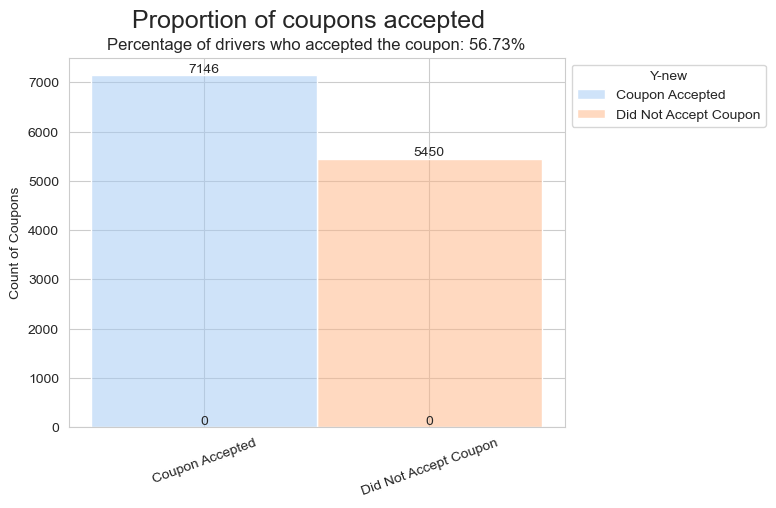

In [1270]:
# Calculate the number of drivers who accepted the coupon, and divide by total 
# number of coupons distributed. Create a hist plot and display coupon acceptance % as in the subtitle
# 
    
proportion_accepted_coupon = (len(clean_data[clean_data['Y']==1])/len(clean_data)) * 100
proportion_accepted_coupon = format(proportion_accepted_coupon, ".2f")
    
heading = 'Proportion of coupons accepted'
subtitle = "Percentage of drivers who accepted the coupon: " + proportion_accepted_coupon + "%"

ax = sns.histplot(clean_data, x= 'Y-new', hue='Y-new')

# Use help function to plot the chart
# 
render_plot(ax, heading = heading, subtitle = subtitle, 
            xlabel = '', 
            ylabel = 'Count of Coupons',
            plotname = '1-proportion_of_coupons_accepted.png')



---

56.73% of all coupons are accepted

---

5. Use a bar plot to visualize the `coupon` column.

### Visualize coupon distribution by coupon type

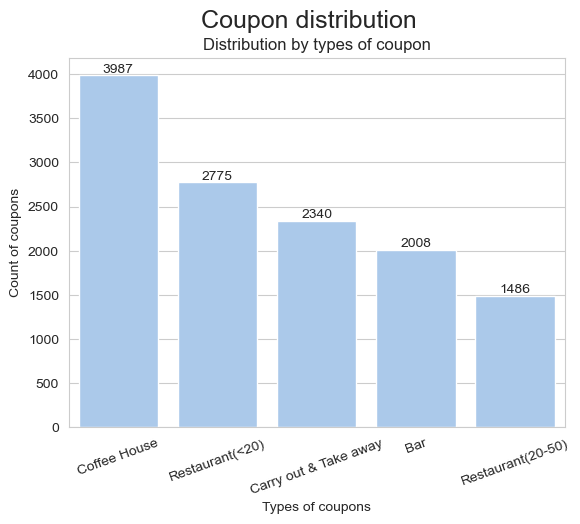

In [1271]:
# Use a bar plot to visualize the distribution of coupons by coupon type
# 

ax = sns.barplot(clean_data.coupon.value_counts())

# Use help function to plot the chart
# 
render_plot(ax,'Coupon distribution', 
            subtitle = 'Distribution by types of coupon', 
            xlabel = 'Types of coupons', 
            ylabel = 'Count of coupons', 
            plotname = '2-distribution_coupon_type.png')


---

Coffee house coupons were offered the most 3987, while expensive restaurants coupons were the least offered 1486

---

6. Use a histogram to visualize the temperature column.

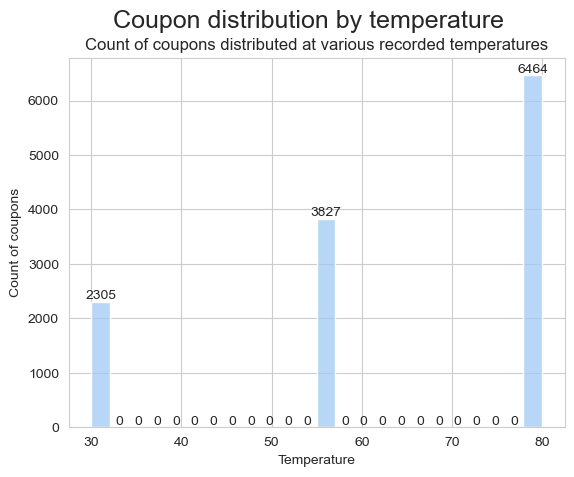

In [1272]:
# Plot temperature column on the sns histplot
# 
ax = sns.histplot(clean_data, x='temperature')

# Use help function to plot the chart
# 
render_plot(ax, heading = 'Coupon distribution by temperature', 
                subtitle='Count of coupons distributed at various recorded temperatures',
                xlabel = 'Temperature',
                ylabel= 'Count of coupons', 
                rotation = 0, 
                plotname = '3-temperature.png')


---

Most coupons were offered (6484) when temperature was 80

---

---

Additional charts to explore more relationship between features and acceptance rates

---

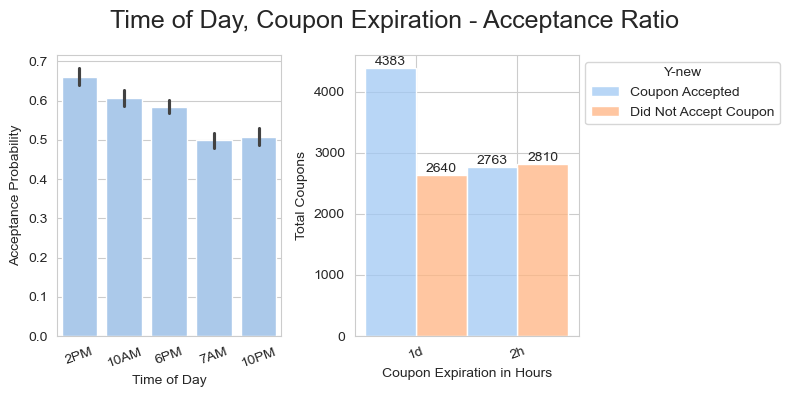

In [1293]:
# Explore Acceptance Rates by time of day and coupon expiration
#

fig, ax = plt.subplots(1,2, figsize=(8, 4))

ax1 = sns.barplot(data=clean_data, x='time', y='Y', ax=ax[0])
render_plot(ax1, xlabel='Time of Day', ylabel='Acceptance Probability', heading='Time of Day and Acceptance Ratio',
            displaybarlabel = False)

ax2 = sns.histplot(data=clean_data, x='expiration', hue='Y-new', ax=ax[1], multiple='dodge', bins=6)
render_plot(ax2, xlabel='Coupon Expiration in Hours', ylabel='Total Coupons', heading='Time of Day, Coupon Expiration - Acceptance Ratio')

fig.tight_layout()


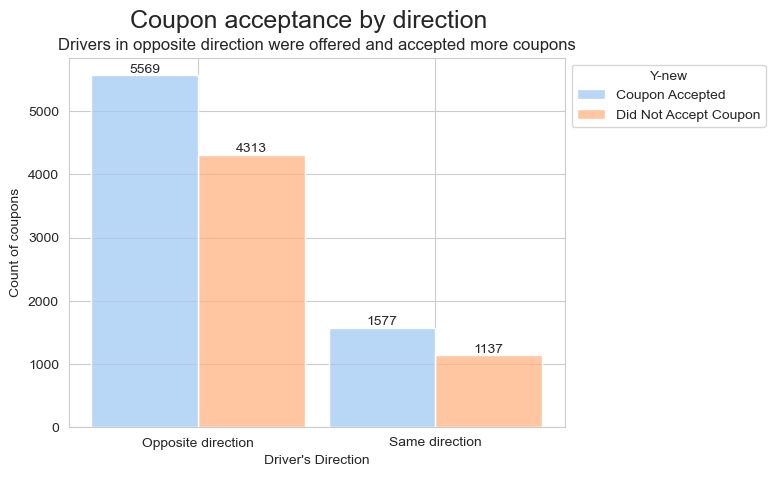

In [1274]:
# Explore the coupons accepted by direction of the driver
# 
ax = sns.histplot(clean_data, 
                 x ='direction_same_new', 
                 multiple="dodge",
                 hue='Y-new', 
                 shrink=.9
                 )

# Use help function to plot the chart
# 
render_plot(ax, heading = 'Coupon acceptance by direction', 
                subtitle='Drivers in opposite direction were offered and accepted more coupons',
                xlabel = "Driver's Direction",
                ylabel= 'Count of coupons', 
                rotation=0, 
                plotname = '4-direction.png')

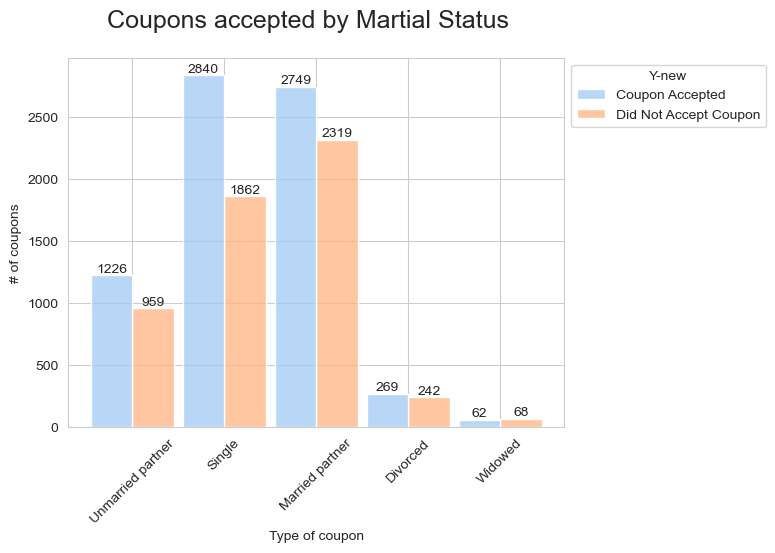

In [1275]:
# Explore acceptance of coupons by marital status of the driver
# 
ax = sns.histplot(clean_data, x='maritalStatus',                  
                  multiple="dodge", 
                  hue='Y-new',
                  shrink=.9)

# Use help function to plot the chart
# 
render_plot(ax,
            heading = 'Coupons accepted by Martial Status',
            xlabel='Type of coupon', ylabel= '# of coupons',
            rotation=45)


---

Single and married partners were offered and accepted the most number of coupons

---

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.  

1. Create a new `DataFrame` that contains just the bar coupons.


In [1276]:
# Create a new data frame that subsets all bar coupons
# 
bar_coupons = clean_data[clean_data['coupon'] == 'Bar']

2. What proportion of bar coupons were accepted?


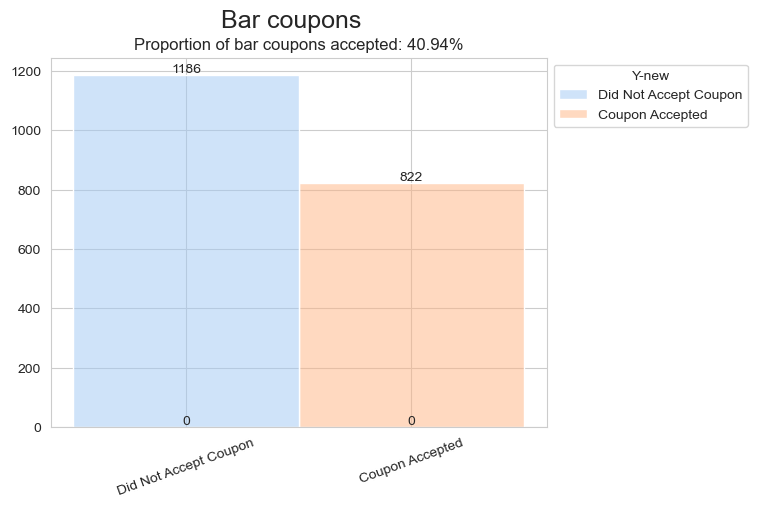

In [1277]:
# Calculate the total number of bar coupons accepted and divide by the total 
#   number of bar coupons distributed.
#   Additionally display the % of bar coupons accepted as a percentage on the subtitle
#

ax = sns.histplot(bar_coupons, x='Y-new', hue='Y-new')

proportion_bar_coupons_accepted = len(bar_coupons[bar_coupons['Y'] == 1])/len(bar_coupons)
proportion_bar_coupons_accepted = proportion_bar_coupons_accepted * 100
proportion_bar_coupons_accepted = format(proportion_bar_coupons_accepted, ".2f")

subtitle = "Proportion of bar coupons accepted: " + proportion_bar_coupons_accepted + "%"

# Use help function to plot the chart
# 
render_plot(ax,
            heading = "Bar coupons", 
            subtitle=subtitle, 
            plotname = '5-bar_coupon_acceptance.png')


3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.


Total Bar Coupons distributed:  2008
Coupons accepted by drivers who go to bar three or fewer times:  661
Coupons accepted by drivers who go to bar more than three times:  153


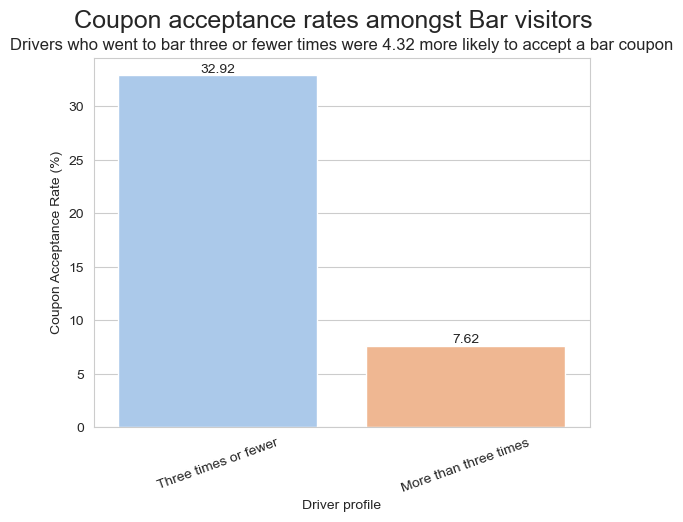

In [1278]:
# Create list of values for the conditions to be checked, and use these lists as variables in 
#   the data frame's query function
# 

bar_morethanthreetimes = ['4~8', 'gt8']
bar_threeorfewertimes = ['never', '1~3']

morethanthreetimes = (bar_coupons.query('Bar == @bar_morethanthreetimes')).Y.value_counts().loc[1]
threeorfewertimes = (bar_coupons.query('Bar == @bar_threeorfewertimes')).Y.value_counts().loc[1]

# Print values for verifying the results in the plot
# 
print("Total Bar Coupons distributed: ", len(bar_coupons))
print("Coupons accepted by drivers who go to bar three or fewer times: ", threeorfewertimes)
print("Coupons accepted by drivers who go to bar more than three times: ", morethanthreetimes)

# Create a data dictionary and data frame for plotting the proportions
# 
dict = {'Question': ['Three times or fewer', 'More than three times'], 
        'Acceptance' : [threeorfewertimes/len(bar_coupons),\
                        morethanthreetimes/len(bar_coupons)] }

df = pd.DataFrame(dict)
df.Acceptance = (df.Acceptance * 100).round(2)
df.sort_values(by = 'Acceptance', inplace=True, ascending=False)

# render the plot
# 
ax = sns.barplot(df, x='Question', y='Acceptance', hue = 'Question')

format(threeorfewertimes/morethanthreetimes, ".2f")
subtitle = "Drivers who went to bar three or fewer times were " + format(threeorfewertimes/morethanthreetimes, ".2f") + \
            " more likely to accept a bar coupon"

# Use help function to plot the chart
#             
render_plot(ax, heading='Coupon acceptance rates amongst Bar visitors', 
            subtitle=subtitle,
            xlabel = 'Driver profile', 
            ylabel = 'Coupon Acceptance Rate (%)',
            plotname='6-bar_three_or_fewertimes.png')


4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


Total Bar Coupons distributed:  2008
Total coupons accepted:  822
Coupons accepted by drivers who go to bar more than once a month and are > 25 yrs of age :  292
Coupons accepted by all others:  530


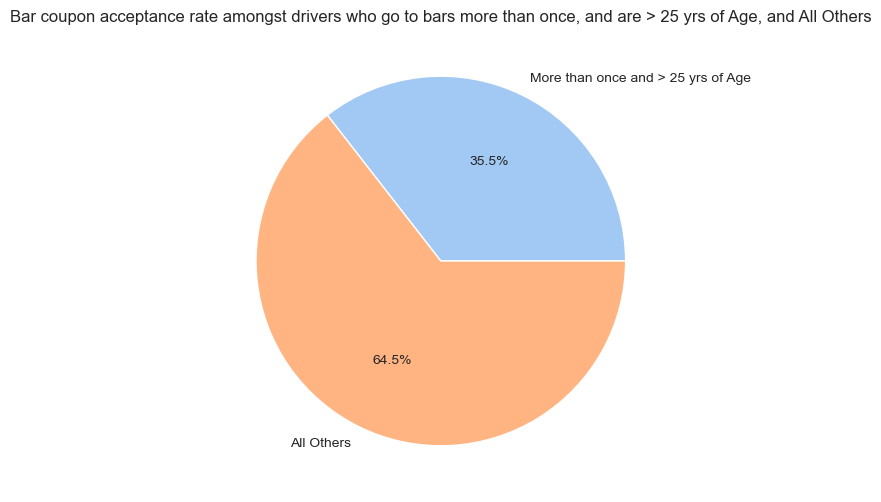

In [1279]:
# Use a pie plot to compare the acceptance rates of coupons amongst drivers who go to bar once and month and 
#   are > 25 yrs of age, vs all the others
# 
age_gt_25 = ['26', '31', '36', '41', '46', '50plus']
bar_morethan_once_month = ['1~3', '4~8', 'gt8']

# Compute the drivers who go to bar once and month and are > 25 yrs of age, vs all the others
# Calculate the others by subtracting this number from the total number of coupons accepted
# 
morethanoncemonth_gt25age = bar_coupons.query('Y == 1 & Bar == @bar_morethan_once_month & age == @age_gt_25').Y.value_counts().loc[1]
barcoupons_accepted_by_others = len(bar_coupons.query('Y == 1')) - morethanoncemonth_gt25age

# For debugging purposes
# 
print("Total Bar Coupons distributed: ", len(bar_coupons))
print("Total coupons accepted: ", len(bar_coupons.query('Y == 1')))
print("Coupons accepted by drivers who go to bar more than once a month and are > 25 yrs of age : ", morethanoncemonth_gt25age)
print("Coupons accepted by all others: ", barcoupons_accepted_by_others)

# Create a pie plot to show this distribution
# 
data = [morethanoncemonth_gt25age/len(bar_coupons), barcoupons_accepted_by_others/len(bar_coupons)]
keys = ["More than once and > 25 yrs of Age", "All Others"]

sns.set_style("whitegrid")
plt.figure(figsize=(6,6))
ax = plt.pie(data, labels=keys,  autopct='%1.1f%%')
plt.title('Bar coupon acceptance rate amongst drivers who go to bars more than once, and are > 25 yrs of Age, and All Others')
plt.savefig('plots/7-bar_morethanonce_gt25.png',bbox_inches='tight')
plt.show()

5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.


Total coupons distributed to drivers who go to bars more than once a month, 
 do not have kids and are in non-farming jobs: 551


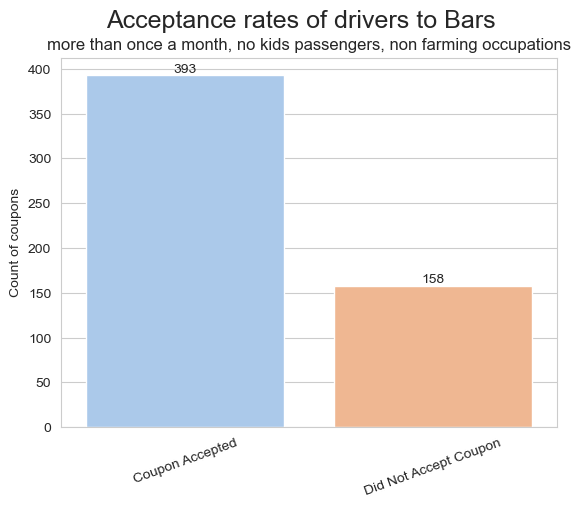

In [1280]:
# Check for drivers with the said condition, and compare acceptance rates
# 

# Use lists to check for conditions within the dataframe's query function
# 
passengers_notkids = 'Kid(s)'
occupation_farming = 'Farming Fishing & Forestry'
bar_morethan_once_month = ['1~3', '4~8', 'gt8']

bars_oncemonth_withnokids_nonfarming = bar_coupons.query('coupon == "Bar" & \
    passanger != @passengers_notkids & \
    occupation != @occupation_farming & \
    Bar == @bar_morethan_once_month')
print("Total coupons distributed to drivers who go to bars more than once a month, \n do not have kids and are in non-farming jobs:", len(bars_oncemonth_withnokids_nonfarming))

# Render the plot
# 
ax = sns.countplot(bars_oncemonth_withnokids_nonfarming, x="Y-new", hue='Y-new')

# Use help function to plot the chart
# 
render_plot(ax, heading='Acceptance rates of drivers to Bars', 
            subtitle='more than once a month, no kids passengers, non farming occupations',
            ylabel = 'Count of coupons', 
            plotname='8-bar_morethanoncemonth_nokids_nonfarming.png')


6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K.



Goes to bars more than once/month, passengers that were not a kid, and was not widowed (total coupons offered, accepted) 
 2008 393
go to bars more than once a month and are under the age of 30 
 2008 249
go to cheap restaurants more than 4 times a month and income is less than 50K 
 2775 1044
                                    Question  Acceptance
2     Cheap restaurants:\n with income < 50k       37.62
0  Bar: Once a month,\n no kids, not widowed       19.57
1              Bar: Once a month,\n age < 30       12.40


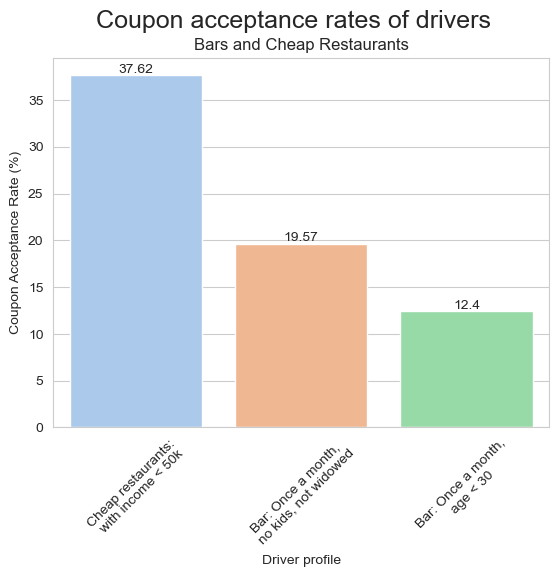

In [1281]:
# Define lists for comparisons with the data-frame's query functions
#
bar_morethan_once_month = ['1~3', '4~8', 'gt8']
passengers_kids = 'Kid(s)'
widowed = 'Widowed'

# Driver profile 1: Goes to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
#
q1_coupons_accepted = bar_coupons.query('passanger != @passengers_kids & \
                                                        Bar == @bar_morethan_once_month & \
                                                        maritalStatus != @widowed') \
                                        .Y.value_counts().loc[1]
q1_coupons_distributed = len(bar_coupons)
print("Goes to bars more than once/month, passengers that were not a kid, and was not widowed (total coupons offered, accepted) \n", \
                q1_coupons_distributed, q1_coupons_accepted)

# Driver profile 2: Goes to bars more than once a month and are under the age of 30 *OR*
# 
age_le_30 = ['21', 'below21', '26']
q2_coupons_accepted = bar_coupons.query('Bar == @bar_morethan_once_month & \
                                        age == @age_le_30').Y.value_counts().loc[1]
q2_coupons_distributed = len(bar_coupons)

print("go to bars more than once a month and are under the age of 30 \n", \
                q2_coupons_distributed, q2_coupons_accepted)

# Driver profile 3: Goes to cheap restaurants more than 4 times a month and income is less than 50K
# 
cheap_restaurants = 'Restaurant(<20)'
income_lt50k = ['Less than $12500', '$12500 - $24999', '$25000 - $37499','$37500 - $49999']

q3_coupons_accepted = clean_data.query('coupon == @cheap_restaurants & \
                                                  income == @income_lt50k').Y.value_counts().loc[1]
q3_coupons_distributed = len(clean_data.query('coupon == @cheap_restaurants'))

print("go to cheap restaurants more than 4 times a month and income is less than 50K \n", \
                q3_coupons_distributed, q3_coupons_accepted)

data = {'Question': ['Bar: Once a month,\n no kids, not widowed', 'Bar: Once a month,\n age < 30', 'Cheap restaurants:\n with income < 50k'], 
        'Acceptance' : [q1_coupons_accepted/q1_coupons_distributed,\
                        q2_coupons_accepted/q2_coupons_distributed, 
                        q3_coupons_accepted/q3_coupons_distributed] }
df = pd.DataFrame(data)
df.Acceptance = df.Acceptance * 100
df = df.round(2)
df.sort_values(by = 'Acceptance', inplace=True, ascending=False)
print(df)

ax = sns.barplot(df, x='Question', y='Acceptance', hue = 'Question')

# Use help function to plot the chart
# 
render_plot(ax, heading='Coupon acceptance rates of drivers', 
            subtitle='Bars and Cheap Restaurants',
            rotation = 45,
            xlabel = 'Driver profile', 
            ylabel = 'Coupon Acceptance Rate (%)', 
            plotname='9-bar_cheap_restaurants.png')

7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

---

### Observations from drivers who accepted bar coupons

 - 2008 bar coupons were distributed out of which 822 (40.94%) were accepted
 - Drivers who went to bar three or fewer times were 4.37 times more likely to accept a bar coupon (669 accepted) v/s those that went more times (153 accepted)
 - Drivers who went to bar more than once a month and were > 25 yrs old accepted coupons 64.5% of the times (530 coupons accepted)
 - Drivers who go to bars more than once a month, do not have kids and are in non-farming jobs, accepted coupons 71% of the times (393 out of 551 coupons accepted)
 
 #### Hypothesis

 - Drivers who go to bars atleast once a month, are older than 25, and do not have kids, on average are more likely accept a bar coupon, than the others

---



### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  

**Explore the characteristics of drivers who accept coupons to cheap restaurants (coupon == Restaurant(<20))**

In [1282]:
# Subset clean daa frame by the coupon for cheap restaurants
# 
cheap_restaurants = clean_data[clean_data['coupon']=='Restaurant(<20)']

# Print the proportions of cheap restaurant coupons to all coupons
#
print("Total number of cheap restaurant coupons distributed : ", len(cheap_restaurants))
print("These are : ", round(len(cheap_restaurants)/len(clean_data)*100, 2), "% of the total coupons distributed")

cheap_restaurants.sample(2)


Total number of cheap restaurant coupons distributed :  2775
These are :  22.03 % of the total coupons distributed


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,Y-new,direction_same_new
1433,Work,Alone,Sunny,55,7AM,Restaurant(<20),1d,Female,36,Married partner,...,1~3,never,1,0,0,0,1,0,Did Not Accept Coupon,Opposite direction
6529,Home,Alone,Sunny,80,10PM,Restaurant(<20),2h,Male,below21,Single,...,gt8,4~8,1,0,0,1,0,0,Did Not Accept Coupon,Same direction


**Examine the acceptance rates of cheap restaurant coupons**

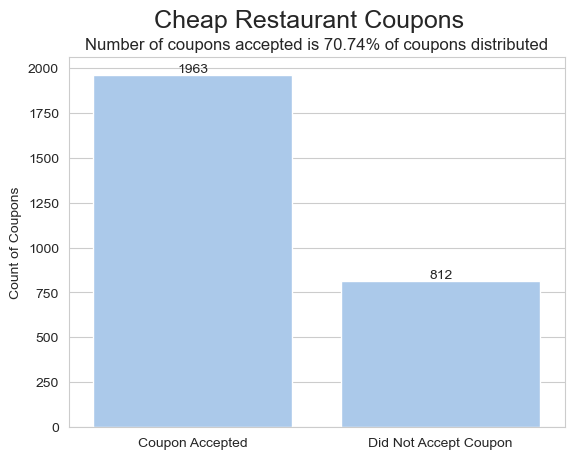

In [1283]:
# Plot the distribution of coupons accepted vs not accepted
# 

coupons_accepted = len(cheap_restaurants.query('Y==1'))

subtitle = "Number of coupons accepted is " + str(round(coupons_accepted/len(cheap_restaurants)*100,2)) + "% of coupons distributed"

ax = sns.countplot(cheap_restaurants, x='Y-new')

# Use help function to plot the chart
# 
render_plot(ax, rotation=0, heading='Cheap Restaurant Coupons', subtitle=subtitle, \
    ylabel='Count of Coupons', 
    plotname='10_cheaprest.png')


**Examine the acceptance of cheap restaurant coupons by drivers who have children as passengers**

In [1284]:
# understand how many observations had children present in the car and whether a male/female was driving the car
# and whether the coupon was accpeted
#
cheap_restaurants.groupby(['gender', 'has_children', 'passanger'])[['Y']].count()


Y
gender has_children passanger     
Female 0            Alone      364
                    Friend(s)  235
                    Partner    117
       1            Alone      348
                    Friend(s)  179
                    Kid(s)     161
                    Partner     12
Male   0            Alone      507
                    Friend(s)  292
                    Kid(s)       3
                    Partner    109
       1            Alone      209
                    Friend(s)  118
                    Kid(s)     103
                    Partner     18

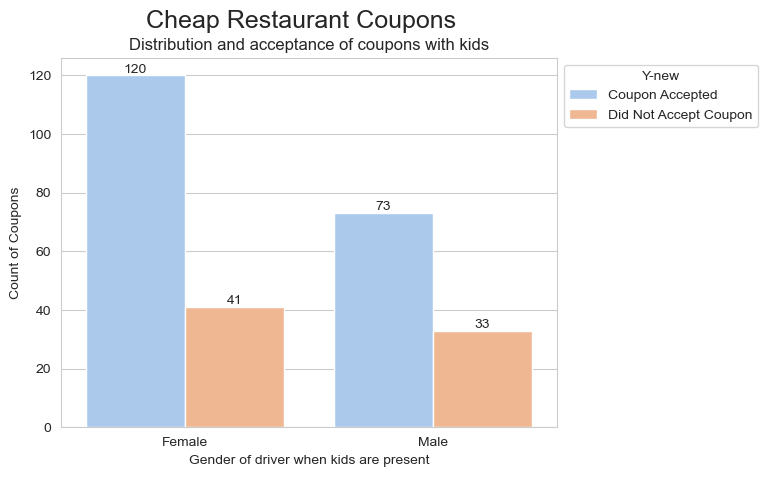

In [1285]:
# 
# 
passenger_kids = 'Kid(s)'

coupons_accepted = cheap_restaurants.query('passanger == @passenger_kids')

ax = sns.countplot(coupons_accepted, x='gender', hue='Y-new')

# Use help function to plot the chart
# 
render_plot(ax, rotation=0, heading='Cheap Restaurant Coupons', \
    subtitle='Distribution and acceptance of coupons with kids', ylabel='Count of Coupons',
    xlabel = 'Gender of driver when kids are present',
    plotname='11_cheaprest_kids_gender.png')

---

*It appears that female drivers with kids receive and accept more coupons than male drivers with kids*

---

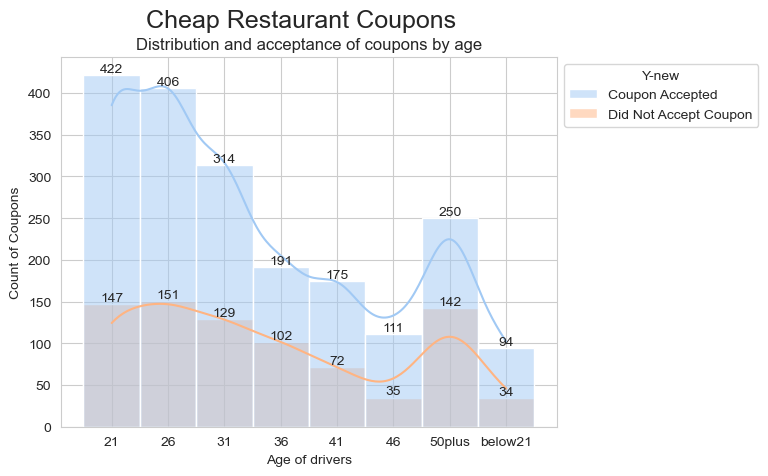

In [1286]:
# Explore cheap restaurant coupons distributed by age
#

ax = sns.histplot(cheap_restaurants.sort_values('age'), x='age', hue='Y-new', kde=True)

# Use help function to plot the chart
# 
render_plot(ax, rotation=0, heading='Cheap Restaurant Coupons', \
    subtitle='Distribution and acceptance of coupons by age', ylabel='Count of Coupons',\
    xlabel='Age of drivers', plotname='12_cheaprest_age.png')



---

*It appears that drivers with passengers age 21, 26, 31 receive farm more coupons than the middle age (36,41,46) drivers. 50plus drivers break this trend and receive more coupons than the middle age drivers*

---

Total number of cheap restaurant coupons:  2775
Total number of coupons after melting the data frame:  8325
                      Y-New           Variable  Value
194         Coupon Accepted   toCoupon_GEQ5min      1
1295  Did Not Accept Coupon   toCoupon_GEQ5min      1
2794        Coupon Accepted  toCoupon_GEQ15min      0
1279        Coupon Accepted   toCoupon_GEQ5min      1
954         Coupon Accepted   toCoupon_GEQ5min      1 



/var/folders/0t/f834b52j5jnfwqmx1l_q6km40000gn/T/ipykernel_1305/1630970613.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=["5 min", "15 min", "25 min"])


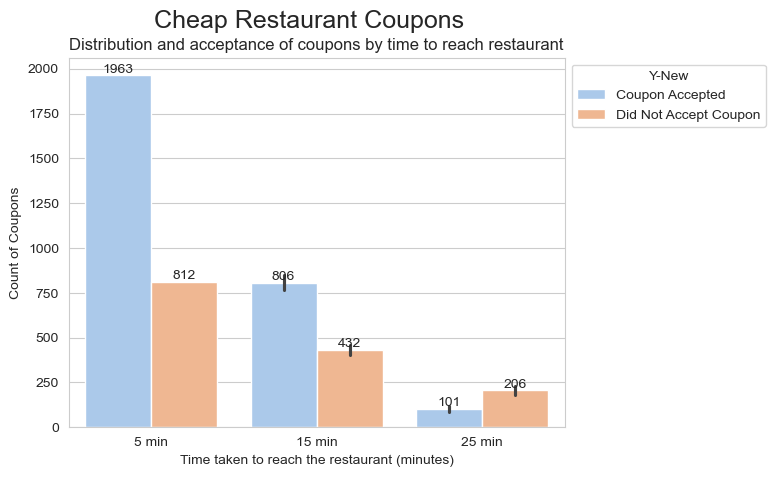

In [1289]:
# Explore the relationship between coupon acceptance and the distance to the cheap restaurants
# 
temp_df = cheap_restaurants[['Y-new', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min']]


# Melt the data frame so we can represent the duration columns in rows and plot them as bars
# 
cheap_restaurants_timetorestaurant = temp_df.melt(id_vars='Y-new').rename(columns=str.title)

print("Total number of cheap restaurant coupons: ", len(cheap_restaurants))
print("Total number of coupons after melting the data frame: ", len(cheap_restaurants_timetorestaurant))
print(cheap_restaurants_timetorestaurant.sample(5), "\n")

#fig, ax1 = plt.subplots(figsize=(6, 6))            # sub plot is not needed here. explore the use of subplots further

ax = sns.barplot(cheap_restaurants_timetorestaurant, x='Variable', y='Value', estimator=sum, hue='Y-New')
ax.set(xticklabels=["5 min", "15 min", "25 min"])

# Use help function to plot the chart
# 
render_plot(ax, rotation=0, heading='Cheap Restaurant Coupons', \
    subtitle='Distribution and acceptance of coupons by time to reach restaurant', \
    ylabel='Count of Coupons',\
    xlabel='Time taken to reach the restaurant (minutes)',
    plotname='13_cheaprest_timetaken.png')


---
### Observations from drivers who were given cheap restaurant coupons

 - 2775 cheap restaurant coupons were distributed out of which 1963 (70.74%) were accepted
 - When kids are present, female drivers were offered 161 coupons out of which they accepted, 120 coupons (75% acceptance rate). Males, on other hand were offered 106 coupons, they accepted 73 (68% acceptance rate)
 - Drivers with passengers age 21, 26, 31 received more coupons than the middle age (36,41,46) drivers. 50plus drivers break this trend and receive more coupons than the middle age drivers
 - Coupons where driving time to the restaurant is 25 min received 307 coupons, and accepted only 101 (32% acceptance rate)
 
 #### Hypothesis

 - Cheap restaurant coupons have a higher likelyhood of acceptance than bar coupons. The acceptance of cheap restaurant coupons increase if female passengers with kids are driving, and the driving time is lower

---

 ### Next Steps and Recommendations

The analysis presented here is very brief and explores only a couple of coupon types. The following next steps are recommended for further analysis and confirmation of findings:

- Explore acceptance rates of other coupon type - such as coffee houses, carry out, and expensive restaurants
- Explore relationships between additional variables such as destination, weather, time of day, expiration, income, has children and acceptance rates of coupons
- Determine the variables that have the strongest co-relation to the target variable i.e. will the driver accept the coupon
- Build a model to predict future acceptance of coupons, given this data set and independent variables

---